This note book is based entirely on a Kaggle jupyter notebook. https://www.kaggle.com/guoday/two-sigma-connect-rental-listing-inquiries/cv-statistics-edited-0-5346-score/notebook

In [98]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
import random
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#input data
train_df=pd.read_json('C:\\Users\\sevda\\Documents\\Data Lab\\Six sigma rental property\\train.json\\train.json')
test_df=pd.read_json('C:\\Users\\sevda\\Documents\\Data Lab\\Six sigma rental property\\test.json\\test.json')

We will define the XGBoost function

In [99]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        print("Before train function")
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

We will also define a train_model function which splits the train data set into a training and testing data set, then apply the model XGBoost model and returns the best cross validation scores we can get with the model based on the selected variables which are included in the train_X_full dataset

In [100]:
#train_y is the column values we want to predict and train_X_full is the dataset with which we want to work 
def train_model(train_X_full, train_y):


        target_num_map = {'high':0, 'medium':1, 'low':2}
        train_y = np.array(train_y.apply(lambda x: target_num_map[x]))

        cv_scores = []
        kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
        i = 0
        for dev_index, val_index in kf.split(range(train_X_full.shape[0])):
            i = i + 1
            #print(train_X_full.loc(dev_index))
            dev_X, val_X = train_X_full.loc[dev_index], train_X_full.loc[val_index]
            dev_y, val_y = train_y[dev_index], train_y[val_index]
            preds, model = runXGB(dev_X, dev_y, val_X, val_y)
            #print(log_loss(val_y, preds))
            cv_scores.append(log_loss(val_y, preds))
            #print(cv_scores)
            break
        return cv_scores

As part of the feature engineering, we create some basic additional features based on the initial variables.

In [101]:
#basic features
train_df["price_t"] =train_df["price"]/(train_df["bedrooms"] + 1)
test_df["price_t"] = test_df["price"]/(test_df["bedrooms"] + 1) 
train_df["room_sum"] = train_df["bedrooms"]+train_df["bathrooms"] 
test_df["room_sum"] = test_df["bedrooms"]+test_df["bathrooms"] 

# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))


features_to_use=["bathrooms", "bedrooms", "latitude", "longitude", "price","price_t","num_photos", "num_features", "num_description_words","listing_id"]


We will create three levels of manager id valuation based on the number of low, medium and high interest for listing interest.

In [102]:
index=list(range(train_df.shape[0]))
random.shuffle(index)
a=[0]*len(train_df)
b=[0]*len(train_df)
c=[0]*len(train_df)

for i in range(5):
    building_level={}
    for j in train_df['manager_id'].values:
        building_level[j]=[0,0,0]
    test_index=index[int((i*train_df.shape[0])/5):int(((i+1)*train_df.shape[0])/5)]
    train_index=list(set(index).difference(test_index))
    for j in train_index:
        temp=train_df.iloc[j]
        if temp['interest_level']=='low':
            building_level[temp['manager_id']][0]+=1
        if temp['interest_level']=='medium':
            building_level[temp['manager_id']][1]+=1
        if temp['interest_level']=='high':
            building_level[temp['manager_id']][2]+=1
    for j in test_index:
        temp=train_df.iloc[j]
        if sum(building_level[temp['manager_id']])!=0:
            a[j]=building_level[temp['manager_id']][0]*1.0/sum(building_level[temp['manager_id']])
            b[j]=building_level[temp['manager_id']][1]*1.0/sum(building_level[temp['manager_id']])
            c[j]=building_level[temp['manager_id']][2]*1.0/sum(building_level[temp['manager_id']])
train_df['manager_level_low']=a
train_df['manager_level_medium']=b
train_df['manager_level_high']=c



a=[]
b=[]
c=[]
building_level={}
for j in train_df['manager_id'].values:
    building_level[j]=[0,0,0]
for j in range(train_df.shape[0]):
    temp=train_df.iloc[j]
    if temp['interest_level']=='low':
        building_level[temp['manager_id']][0]+=1
    if temp['interest_level']=='medium':
        building_level[temp['manager_id']][1]+=1
    if temp['interest_level']=='high':
        building_level[temp['manager_id']][2]+=1

for i in test_df['manager_id'].values:
    if i not in building_level.keys():
        a.append(0)
        b.append(0)
        c.append(0)
    else:
        a.append(building_level[i][0]*1.0/sum(building_level[i]))
        b.append(building_level[i][1]*1.0/sum(building_level[i]))
        c.append(building_level[i][2]*1.0/sum(building_level[i]))
test_df['manager_level_low']=a
test_df['manager_level_medium']=b
test_df['manager_level_high']=c

#features_to_use.append('manager_level_low') 
#features_to_use.append('manager_level_medium') 
#features_to_use.append('manager_level_high')

Label encoding transformation of the categorical variables.

In [103]:
#categorical = ["display_address", "manager_id", "building_id", "street_address"]
categorical = ["manager_id", "building_id"]
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)

Introducing the price diff variable

In [104]:
train_group_by = train_df[["bedrooms", "price"]].groupby(["bedrooms"]).median()
train_group_by = train_group_by.add_suffix('_median').reset_index()

train_df = train_df.merge(train_group_by, left_on=['bedrooms'], right_on=['bedrooms'], how='outer')
test_df = test_df.merge(train_group_by, left_on=['bedrooms'], right_on=['bedrooms'], how='left')

train_df["price_diff"] = train_df["price"] - train_df["price_median"]
test_df["price_diff"] = test_df["price"] - test_df["price_median"]

We will use the created date and will add the day of year, week of year and a number of other data related variables.

In [105]:
train_df["created"] = pd.to_datetime(train_df["created"])
train_df["date"]= train_df["created"].dt.date

train_df["dayofyear"] = train_df["created"].dt.dayofyear
train_df["weekofyear"] = train_df["created"].dt.weekofyear
train_df["weekday"] = train_df["created"].dt.weekday
train_df["hour"] = train_df["created"].dt.hour

test_df["created"] = pd.to_datetime(test_df["created"])
test_df["date"]= test_df["created"].dt.date

test_df["dayofyear"] = test_df["created"].dt.dayofyear
test_df["weekofyear"] = test_df["created"].dt.weekofyear
test_df["weekday"] = test_df["created"].dt.weekday
test_df["hour"] = test_df["created"].dt.hour

Adding the count of apartments available for rent in each building.

In [106]:
building_id_group_by = train_df[["street_address", "building_id"]].groupby(["building_id"]).count()
building_id_group_by = building_id_group_by.add_suffix('_count').reset_index()

train_df = train_df.merge(building_id_group_by, left_on=['building_id'], right_on=['building_id'], how='inner')
test_df = test_df.merge(building_id_group_by, left_on=['building_id'], right_on=['building_id'], how='left')

Adding a density description variable for the location of the apartments.

In [107]:
train_df["pos"] = train_df.longitude.round(3).astype(str) + '_' + train_df.latitude.round(3).astype(str)
test_df["pos"] = test_df.longitude.round(3).astype(str) + '_' + test_df.latitude.round(3).astype(str)

vals = train_df['pos'].value_counts()
dvals = vals.to_dict()
train_df["density"] = train_df['pos'].apply(lambda x: dvals.get(x, vals.min()))
test_df["density"] = test_df['pos'].apply(lambda x: dvals.get(x, vals.min()))

Assessing the manager skill based on the postings with high and low interest.

In [108]:
train_df['manager_skill'] = train_df['manager_level_high']*3 + train_df['manager_level_medium']*2 + train_df['manager_level_low']
test_df['manager_skill'] = test_df['manager_level_high']*3 + test_df['manager_level_medium']*2 + test_df['manager_level_low']

Adding a listing difference variable which is a reflection of the position under which a listing appears.

In [109]:
dayofyear_group_by = train_df[["listing_id", "dayofyear"]].groupby(["dayofyear"]).min()
dayofyear_group_by = dayofyear_group_by.add_suffix('_min').reset_index()

train_df = train_df.merge(dayofyear_group_by, left_on=['dayofyear'], right_on=['dayofyear'], how='left')
train_df['listing_difference'] = train_df['listing_id'] - train_df['listing_id_min']

test_df = test_df.merge(dayofyear_group_by, left_on=['dayofyear'], right_on=['dayofyear'], how='left')
test_df['listing_difference'] = test_df['listing_id'] - test_df['listing_id_min']

Performing clustering based on the latitude and longitude information in order to form rental unit clusters based on proximity. The idea for teh clustering and part of the code was taken from https://www.kaggle.com/luisblanche/two-sigma-connect-rental-listing-inquiries/price-compared-to-neighborhood-median .

In [151]:
features_to_use=["bathrooms", "bedrooms", "latitude", "longitude", "listing_difference", "price","price_t","num_photos", "num_features", "num_description_words","listing_id"]

features_to_use.append("price_diff")
features_to_use.append("dayofyear")
features_to_use.append("weekofyear")
features_to_use.append("weekday")
features_to_use.append("hour")
#features_to_use.append("price_diff")
#features_to_use.append("longitude")
#features_to_use.append("latitude")
features_to_use.append("street_address_count")
features_to_use.append("manager_level_low")
features_to_use.append("manager_level_medium")
features_to_use.append("manager_level_high")
#features_to_use.append("pos")
features_to_use.append("density")
features_to_use.append("manager_skill")
#features_to_use.append("listing_difference")

In [111]:
from sklearn.cluster import Birch
import matplotlib.pyplot as plt

def cluster_latlon(n_clusters, train_df, test_df):  
    train_df['type_df'] = "train"
    test_df['type_df'] = "test"
    
    data = pd.concat([train_df, test_df])
    #split the data between "around NYC" and "other locations" basically our first two clusters 
    data_c=data[(data.longitude>-74.05)&(data.longitude<-73.75)&(data.latitude>40.4)&(data.latitude<40.9)]
    data_e=data[~(data.longitude>-74.05)&(data.longitude<-73.75)&(data.latitude>40.4)&(data.latitude<40.9)]
    #put it in matrix form
    coords=data_c.as_matrix(columns=['latitude', "longitude"])
    
    brc = Birch(branching_factor=100, n_clusters=n_clusters, threshold=0.01,compute_labels=True)

    brc.fit(coords)
    clusters=brc.predict(coords)
    data_c["cluster_"+str(n_clusters)]=clusters
    data_e["cluster_"+str(n_clusters)]=-1 #assign cluster label -1 for the non NYC listings 
    data=pd.concat([data_c,data_e])
    
    res_train_df = data[(data.type_df == "train")]
    res_test_df = data[(data.type_df == "test")]
    
    #Visualizing the clusters
    plt.scatter(data_c["longitude"], data_c["latitude"], c=data_c["cluster_"+str(n_clusters)], s=10, linewidth=0.1)
    plt.title(str(n_clusters)+" Neighbourhoods from clustering")
    plt.show()
    return res_train_df, res_test_df 

Performing clustering with 30 clusters and presenting the results on a map. Other number of clusters have been tried in the model but their overall log loss scores on the test set are pretty close. For that reason an arbitrary number of 30 clusters is selected. We are aiming for a reasonable number of clusters, where the clusters are forming nice and clean regions on the map and at the same time each cluster has plenty of data which will help us with forming the median price value. 

In [ ]:
train_X_full, test_X_full = cluster_latlon(30, train_df, test_df)

train_df["cluster_30"] = train_X_full["cluster_30"]
test_df["cluster_30"] = test_X_full["cluster_30"]

features_to_use.append("cluster_30")

train_X_sel = train_X_full[features_to_use]
test_X_sel = test_X_full[features_to_use]

train_model(train_X_sel, train_df['interest_level'])

C:\Users\sevda\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sevda\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We will try to explore other variables that may be derived based on the cluster to which the rental unit belongs, such as the median price based on cluster id, number of bedrooms and number of bathrooms. Based on the results, we can see that introducing the variables, increases significantly the log loss. Therefore we will not include this variables in the final model.

C:\Users\sevda\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sevda\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


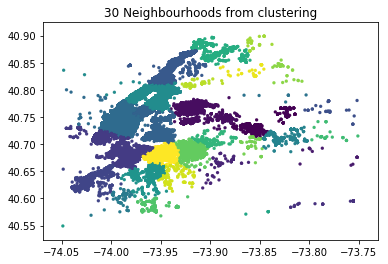

[0]	train-mlogloss:1.0488	test-mlogloss:1.0507
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:1.00775	test-mlogloss:1.01118
[2]	train-mlogloss:0.972497	test-mlogloss:0.977582
[3]	train-mlogloss:0.942228	test-mlogloss:0.948856
[4]	train-mlogloss:0.916273	test-mlogloss:0.924317
[5]	train-mlogloss:0.89393	test-mlogloss:0.903315
[6]	train-mlogloss:0.874446	test-mlogloss:0.885194
[7]	train-mlogloss:0.857381	test-mlogloss:0.869446
[8]	train-mlogloss:0.842499	test-mlogloss:0.855892
[9]	train-mlogloss:0.829522	test-mlogloss:0.844174
[10]	train-mlogloss:0.818484	test-mlogloss:0.834302
[11]	train-mlogloss:0.808505	test-mlogloss:0.82561
[12]	train-mlogloss:0.79978	test-mlogloss:0.818086
[13]	train-mlogloss:0.79232	test-mlogloss:0.811653
[14]	train-mlogloss:0.785463	test-mlogloss:0.806044
[15]	train-mlogloss:0.779089	test-mlogloss:0.800623
[16]	train-mlogloss:0.773485	test-mlo

[0.76687707300267205]

In [150]:
train_X_full, test_X_full = cluster_latlon(30, train_df, test_df)

train_group_by = train_X_full[["cluster_30","bedrooms", "bathrooms", "price"]].groupby(["cluster_30","bedrooms","bathrooms"]).median()
train_group_by = train_group_by.add_suffix('_med').reset_index()

train_X_full = train_X_full.merge(train_group_by, left_on=["cluster_30","bedrooms", "bathrooms"], right_on=["cluster_30","bedrooms", "bathrooms"], how='outer')
test_X_full = test_X_full.merge(train_group_by, left_on=["cluster_30","bedrooms","bathrooms"], right_on=["cluster_30","bedrooms","bathrooms"], how='left')

train_X_full["price_comparison"] = train_X_full["price"] - train_X_full["price_med"]
test_X_full["price_comparison"] = test_X_full["price"] - test_X_full["price_med"]
#print(train_X_full.columns.values)

train_df["cluster_30"] = train_X_full["cluster_30"]
test_df["cluster_30"] = test_X_full["cluster_30"]

train_df["price_comparison"] = train_X_full["price_comparison"]
test_df["price_comparison"] = test_X_full["price_comparison"]

features_to_use.append("cluster_30")
features_to_use.append("price_comparison")

train_X_sel = train_X_full[features_to_use]
test_X_sel = test_X_full[features_to_use]

train_model(train_X_sel, train_df['interest_level'])


C:\Users\sevda\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sevda\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


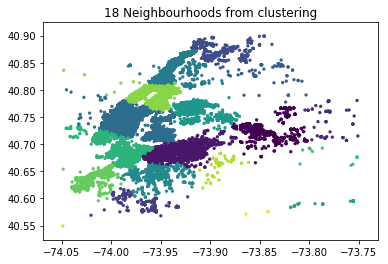

['bathrooms' 'bedrooms' 'building_id' 'created' 'date' 'dayofyear'
 'density' 'description' 'display_address' 'features' 'hour'
 'interest_level' 'latitude' 'listing_difference' 'listing_id'
 'listing_id_min' 'longitude' 'manager_id' 'manager_level_high'
 'manager_level_low' 'manager_level_medium' 'manager_skill'
 'num_description_words' 'num_features' 'num_photos' 'photos' 'pos' 'price'
 'price_diff' 'price_median' 'price_t' 'room_sum' 'street_address'
 'street_address_count' 'type_df' 'weekday' 'weekofyear' 'cluster_18']
['bathrooms', 'bedrooms', 'latitude', 'longitude', 'listing_difference', 'price', 'price_t', 'num_photos', 'num_features', 'num_description_words', 'listing_id', 'price_diff', 'dayofyear', 'weekofyear', 'weekday', 'hour', 'street_address_count', 'manager_level_low', 'manager_level_medium', 'manager_level_high', 'density', 'manager_skill', 'cluster_18']
['bathrooms' 'bedrooms' 'latitude' 'longitude' 'listing_difference' 'price'
 'price_t' 'num_photos' 'num_features' '

In [119]:
train_X_full, test_X_full = cluster_latlon(18, train_df, test_df)

print(train_X_full.columns.values)

features_to_use_upd = features_to_use
features_to_use_upd.append("cluster_18")
#
print(features_to_use)
#features_to_use_upd.remove("cluster_9")
train_X_sel = train_X_full[features_to_use_upd]
test_X_sel = test_X_full[features_to_use_upd]

print(train_X_sel.columns.values)

train_model(train_X_sel, train_df['interest_level'])

features_to_use_upd.remove("cluster_18")

In [96]:
print(features_to_use_upd)

['bathrooms', 'bedrooms', 'latitude', 'longitude', 'listing_difference', 'price', 'price_t', 'num_photos', 'num_features', 'num_description_words', 'listing_id', 'price_diff', 'dayofyear', 'weekofyear', 'weekday', 'hour', 'street_address_count', 'manager_level_low', 'manager_level_medium', 'manager_level_high', 'density', 'manager_skill', 'cluster_9', 'cluster_9']


Now it is important ot make a decision how many clusters to use for this particular data set.

We are adding the newly created variable to features_to_use.

Transforming the feature variable.

In [49]:
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
print(train_df["features"].head())
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

col_desc = ['desc_'+ i for i in tfidf.get_feature_names()] 
count_vect_df = pd.DataFrame(tr_sparse.todense(), columns=col_desc)
train_X_full = pd.concat([train_df[features_to_use].reset_index(),count_vect_df],axis=1)

count_vect_test_df = pd.DataFrame(te_sparse.todense(), columns=col_desc)
test_X_full = pd.concat([test_df[features_to_use].reset_index(),count_vect_test_df],axis=1)

0                                                     
1                                                     
2                                                     
3          Doorman Elevator Dishwasher Hardwood_Floors
4    Fireplace Dining_Room Balcony Doorman Elevator...
Name: features, dtype: object


Source for part of the code https://www.kaggle.com/ug2409/two-sigma-connect-rental-listing-inquiries/using-description-as-the-only-feature-72-cv

In [50]:
print(test_X_full.shape)
print(train_X_full.shape)

(74659, 223)
(49352, 223)


Now we will combine the newly created feature variables, which represent whether a feature is present or not, with the initial data frame

In [51]:
#Maybe we do not need this part
#train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
#test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
#print(train_X.shape, test_X.shape)

In [81]:
train_model(train_X_full, train_df['interest_level'])

[0]	train-mlogloss:1.03303	test-mlogloss:1.03433
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:0.976144	test-mlogloss:0.978975
[2]	train-mlogloss:0.927146	test-mlogloss:0.931413
[3]	train-mlogloss:0.884742	test-mlogloss:0.890487
[4]	train-mlogloss:0.848655	test-mlogloss:0.855892
[5]	train-mlogloss:0.817034	test-mlogloss:0.825638
[6]	train-mlogloss:0.788661	test-mlogloss:0.798492
[7]	train-mlogloss:0.76398	test-mlogloss:0.775082
[8]	train-mlogloss:0.742216	test-mlogloss:0.754436
[9]	train-mlogloss:0.722461	test-mlogloss:0.73599
[10]	train-mlogloss:0.705488	test-mlogloss:0.720167
[11]	train-mlogloss:0.690404	test-mlogloss:0.706025
[12]	train-mlogloss:0.676374	test-mlogloss:0.693337
[13]	train-mlogloss:0.663468	test-mlogloss:0.681635
[14]	train-mlogloss:0.651882	test-mlogloss:0.671117
[15]	train-mlogloss:0.641458	test-mlogloss:0.661819
[16]	train-mlogloss:0.63222	tes

[0.54046477515564872]

In [87]:
# not needed
train_X_full = train_X_full.drop("listing_id", axis=1)
test_X_full = test_X_full.drop("listing_id", axis=1)

In [16]:
#preds, model = runXGB(train_X, train_y, test_X, num_rounds=300)
preds, model = runXGB(train_X_full, train_y, test_X_full, num_rounds=300)

out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("xgb_starter_results_v11.csv", index=False)

Before train function


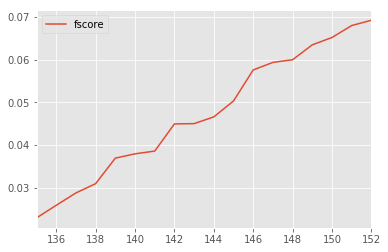

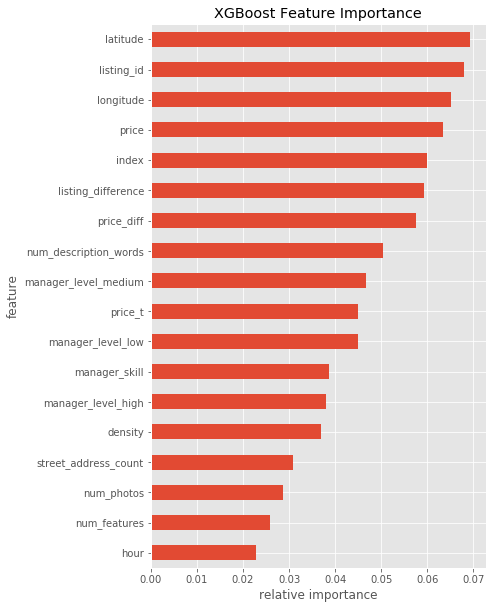

In [85]:
from matplotlib import pylab as plt
from xgboost import plot_tree

importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
df = df[df['fscore']>0.02]

plt.style.use('ggplot') 

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

Transforming the initial variabels by using a factor analysis.

In [64]:

#from sklearn.decomposition import FactorAnalysis
#iris = load_iris()
#X, y = train_X_full, train_y
#train_X_full.info()
#print(train_X_full.columns.values)

from sklearn import decomposition, preprocessing
#print(train_X_full.describe())
print(test_X_full[features_to_use].describe())
#train_X_full.fillna(0, inplace=True)
test_X_full.fillna(0, inplace=True)
#print(type(train_X_full))
#print(train_X_full.isinf().sum().sum())
print(test_X_full.isnull().sum().sum())

#for col_name in test_X_full.columns.values:
#    print(col_name)
#    print(test_X_full[col_name].isnull().sum().sum())

train_X_normal_df = preprocessing.scale(train_X_full) # Normalization
test_X_normal_df = preprocessing.scale(test_X_full) 

fa = decomposition.FactorAnalysis()
train_X_factor_df = fa.fit_transform(train_X_normal_df)
test_X_factor_df = fa.transform(test_X_normal_df)

print (train_X_factor_df) # Factor loadings


#factor = FactorAnalysis(random_state=101).fit(train_X_full)

          bathrooms      bedrooms      latitude     longitude  \
count  74659.000000  74659.000000  74659.000000  74659.000000   
mean       1.212915      1.544663     40.735060    -73.945282   
std        0.649820      1.107014      0.806687      1.487795   
min        0.000000      0.000000      0.000000   -121.488000   
25%        1.000000      1.000000     40.727800    -73.991800   
50%        1.000000      1.000000     40.751600    -73.977700   
75%        1.000000      2.000000     40.774300    -73.954700   
max      112.000000      7.000000     42.872700      0.000000   

       listing_difference         price        price_t    num_photos  \
count        74659.000000  7.465900e+04   74659.000000  74659.000000   
mean          5490.850989  3.749033e+03    1631.330597      5.620193   
std          34640.183017  9.713092e+03    4482.208640      3.641383   
min            -82.000000  1.000000e+00       0.333333      0.000000   
25%           1291.000000  2.495000e+03    1065.000000

In [65]:
print(train_X_factor_df.shape)

(49352, 223)


In [44]:
remove_vars = ["latitude", "longitude", "price_diff", "price", "num_description_words", "price_t"]

all_results_df = out_df
for var in remove_vars:
    print(var)
    train_X_partial = train_X_full.drop(var, axis=1)
    test_X_partial= test_X_full.drop(var, axis=1)
    print("before xgboost")
    preds, model = runXGB(train_X_partial, train_y, test_X_partial, num_rounds=300)
    print("sfter xgboost")
    out_df = pd.DataFrame(preds)
    out_df.columns = ["high", "medium", "low"]
    out_df["listing_id"] = test_df.listing_id.values
    if all_results_df.empty: 
        all_results_df = out_df
    else:
        all_results_df.append(out_df)

final_out_df = all_results_df.groupby(["listing_id"]).mean()
#out_df = out_df.add_suffix('_mean').reset_index()
final_out_df = final_out_df.reset_index()

final_out_df.to_csv("xgb_starter_results_v11.csv", index=False)    

latitude
before xgboost
Before train function
sfter xgboost
longitude
before xgboost
Before train function
sfter xgboost
price_diff
before xgboost
Before train function
sfter xgboost
price
before xgboost
Before train function
sfter xgboost
num_description_words
before xgboost
Before train function
sfter xgboost
price_t
before xgboost
Before train function
sfter xgboost


Predicting and saving the output.

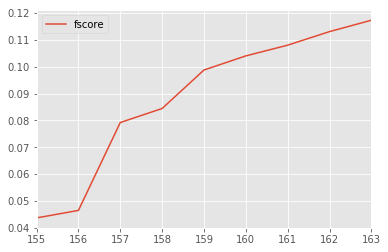

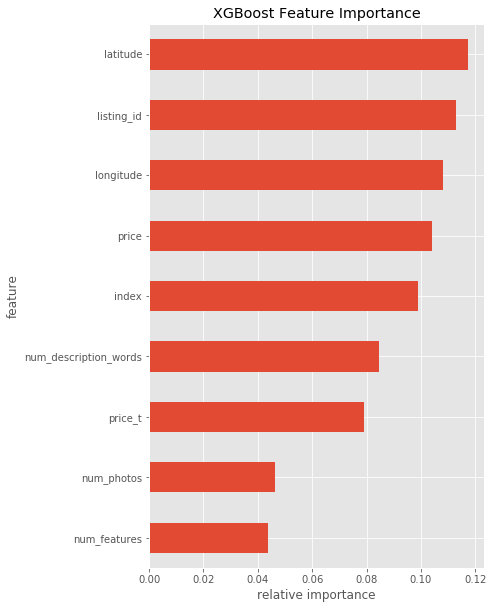

In [126]:
from matplotlib import pylab as plt
from xgboost import plot_tree

importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
df = df[df['fscore']>0.02]

plt.style.use('ggplot') 

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()
